#### THIS PROGRAM LOADS UP THE H SURFACE DATA (Using Hasigma5.f) AND PLOTS IT.

In [2]:
# Libraries used:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from math import *
import scipy as sc
import os
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv # https://ipyvolume.readthedocs.io/en/latest/install.html
from ipywidgets import VBox
from matplotlib import cm
from matplotlib import ticker

# Some general setup for plots:
#mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 17
mpl.rcParams['ytick.labelsize'] = 17
mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['lines.linewidth'] = 11
# mpl.rcParams['lines.markersize'] = 11

In [1]:
# IMPORTANT PARAMETER DEFINITIONS:

# K2:K1 resonance?
K2 = 2
K1 = 1
RESONANCIA = str(K2) + '-' + str(K1) # String "K2-K1"

# Mass and e1,e2 case?
CASO = "m21=20"# "/m12=20/e12=.4.4/"

# Planet to study? (1 or 2)
PLANETA = '1'
 
# DIRECTORIES:
# Common directory root (in Windows use inverted double slash "\\"; in Linux use single slash "/"):
COMUN = "/home/juan/Escritorio/TESIS/"

# H surface data directory:
dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + RESONANCIA +"/"+ CASO + "/metodo2/"
#dir_H = COMUN + "PROGRAMAS/Hamiltoniano/Hasigma_planetario/COPLANAR/" + RESONANCIA + "/prueba/"
file_H = "HSUP" + PLANETA + "_high_RHtol=0.00_AM=0.9000.dat" # filename

# Graphics directory:
dir_graf = COMUN + "DOC/Planetario/" + RESONANCIA + CASO
#dir_graf = "/home/juan/Escritorio/"


# SOME SETUP:
# If ANGLE = 0 => The angles: (0, 360). If ANGLE = 1 => The angles: (-180,180). 
ANGLE = 1
# Use theta instead of sigma? 
THETA = True
# Plot mindis surface?
MINDIS = True
# Filter according RHtol? (encounter if mindis<RHtol)
RHtol = 3
# Save plots? (only normal plots, interactive ones are saved using the widget menu)
GUARDAR = False
# Calidad de imagen? (en ppp, 100 esta ok)
cal = 100
# Formato? ('png', 'jpeg', 'eps', etc)
formato = 'jpeg'
# File names:
fileH_graf = "HSUP." + formato
fileMD_graf = "MDSUP." + formato

In [3]:
# LOAD DATA:
Din_Hsup = pd.read_csv(dir_H + file_H, delimiter=r"\s+")
H = Din_Hsup['R'].values

# Remove outliers (https://www.kite.com/python/answers/how-to-remove-outliers-from-a-pandas-dataframe-in-python) 
z_scores = sc.stats.zscore(H)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
Din_Hsup = Din_Hsup[filtered_entries]      

if (MINDIS):    
    Din_Hsup = Din_Hsup[Din_Hsup['mindis'].values >= RHtol]
    MD_sup = Din_Hsup['mindis'].values
    
# Obtain variables from dataframe:
E_sup = Din_Hsup['e' + PLANETA].values
W_sup = Din_Hsup['deltavarpi'].values % 360
H_sup = -Din_Hsup['R'].values
S_sup = Din_Hsup['sigma1'].values % 360

res_angle = "σ"
if (THETA):
    S_sup = (S_sup - (K2-K1)*W_sup) % 360
    res_angle = "θ"
    
if (ANGLE == 1):
    W_sup = np.where(W_sup>180, W_sup - 360, W_sup)
    S_sup = np.where(S_sup>180, S_sup - 360, S_sup)
    
# Filtro data
#Din_Hsup = Din_Hsup[~( ((S_sup<22)&(S_sup>-22))&~((W_sup<45)&(W_sup>-45)) )]
#Din_Hsup = Din_Hsup[E_sup<0.99]

In [4]:
# Creating a customized colormap to plot in grayscale the model and in colors the numerical integration
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

resol = 32 # Number of levels from 'binary' colormap
Ncm = 25 # 'binary' colormap is concatenated Ncm times 
          # So, the total levels are resol*Ncm

cmap_used = 'gray' # seismic, gray, binary, jet, hsv
top = cm.get_cmap(cmap_used + '_r', resol)
bottom = cm.get_cmap(cmap_used, resol)
newcolors = np.vstack((top(np.linspace(0, 1, resol)), bottom(np.linspace(0, 1, resol))))

for n in range(Ncm): 
    seg1 = cm.get_cmap(cmap_used + '_r', resol)
    seg2 = cm.get_cmap(cmap_used, resol)
    newcolors = np.vstack(( seg1(np.linspace(0, 1, resol)), seg2(np.linspace(0, 1, resol)), newcolors ))

newcm = ListedColormap(newcolors, name='Ngrayscale') # newcm is the new colormap used in the next cell


In [5]:
# INTERACTIVE PLOT OF THE 3D H SURFACE:

# Colors used:
colormap = cm.gist_ncar
#colormap = cm.flag
#colormap = newcm

# *** HAMILTONIAN: ***
# Colormap generation:
#H_map = np.log10(np.abs(H_sup))
H_map = (H_sup-H_sup.min())/(H_sup.max()-H_sup.min())
min_H = H_map.min()
max_H = H_map.max()
znorm = H_map - min_H
znorm /= znorm.ptp()
znorm.min(), znorm.max()
color = colormap(znorm)

# ************************************ FIGURE ****************************************
ipv.style.use('seaborn-darkgrid')
fig1 = ipv.figure()

ipv.scatter(E_sup, W_sup, S_sup, size=1.5, color = color, marker="sphere", fontsize = 1)

# Single point:
#ipv.scatter(np.array([0.08, 0.99]), np.array([-90, 180]), np.array([0, 180]), size=6.5, color = 'orange', marker="sphere")

# Box limits:
ipv.xlim(0, 1)
if (ANGLE == 0):
    ipv.ylim(0, 360)
    ipv.zlim(0, 360)
else:         
    ipv.ylim(-180, 180)
    ipv.zlim(-180, 180)
# labels   
ipv.xyzlabel("e"+PLANETA, "Δϖ", res_angle)
ipv.gcf()

# # Save a movie or gif:
# def set_view(fig, framenr, fraction):
#     ipv.view(fraction*360, (fraction - 0.5) * 180, distance=2 + fraction*2)
#     #fig.angley = fraction*np.pi*2
# ipv.movie('prueba.gif', set_view, fps=5, frames=10)
#ipv.style.axes_off()
ipv.show()
#  NOTE: Sometimes the interactive plot stop working. Try to re-run this cell. If doesn't work, reboot Jupyter Lab. If not, the pc.

Delta_min (in Rhill): 3.00052243
Delta_max (in Rhill): 11.07548369


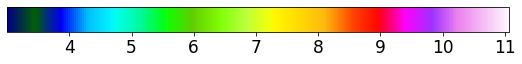

In [6]:
# INTERACTIVE PLOT OF THE 3D mindis SURFACE:
if (MINDIS):
    ipv.style.use('seaborn-darkgrid')
    fig2 = ipv.figure()

    # Colors used:
    colormap2 = cm.gist_ncar
    #colormap2 = cm.flag

    # *** MINDIS: ***
    # Colormap generation:
    min_DIS =  MD_sup.min()
    max_DIS = MD_sup.max()
    znorm2 = MD_sup - min_DIS
    print('Delta_min (in Rhill):', min_DIS)
    print('Delta_max (in Rhill):', max_DIS)
    znorm2 /= znorm2.ptp()
    znorm2.min(), znorm2.max()
    color2 = colormap2(znorm2)

    # * PLOT: *
    ipv.scatter(E_sup, W_sup, S_sup, size=1.5, color = color2, marker="sphere")
   
    # Color bar
    norma2 = mpl.colors.Normalize(vmin=min_DIS, vmax=max_DIS)
    cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), orientation = 'horizontal', shrink = 1.5)
    tick_locator = ticker.MaxNLocator(nbins=10)
    cb.locator = tick_locator
    cb.update_ticks()
    plt.gca().set_visible(False)


    # Box limits:
    ipv.xlim(0, 1)
    if (ANGLE == 0):
        ipv.ylim(0, 360)
        ipv.zlim(0, 360)
    else:         
        ipv.ylim(-180, 180)
        ipv.zlim(-180, 180)
    # labels   
    ipv.xyzlabel("e"+PLANETA, "Δϖ", res_angle)

    ipv.show()
    
#  NOTE: Sometimes the interactive plot stop working. Try to re-run this cell. If doesn't work, reboot Jupyter Lab. If not, the pc.

THE NEXT CELLS ARE TO PLOT NON-INTERACTIVE SURFACE PLOTS:

/tmp/ipykernel_28435/2677347879.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(),


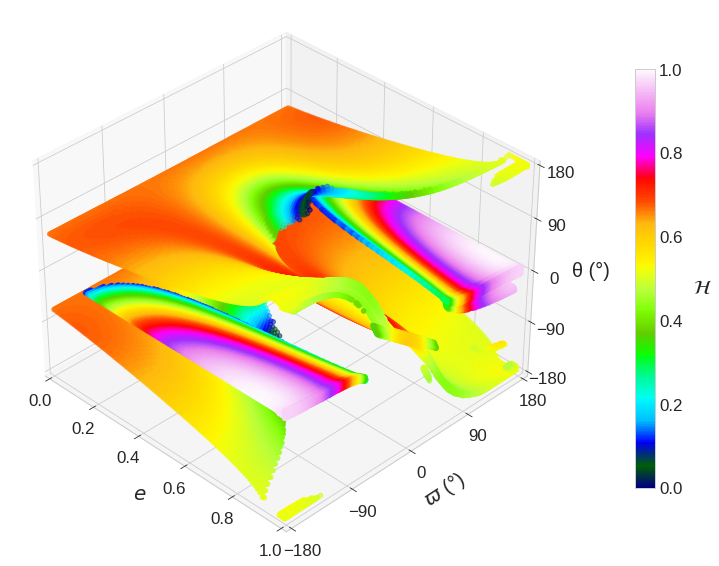

In [7]:
# Normal H surface plot:
plt.style.use('seaborn-whitegrid')
fig3 = plt.figure(figsize=(15,10))
ax = fig3.add_subplot(111, projection='3d')

# Scatter plot:
img1 = ax.scatter(E_sup, W_sup, S_sup, c=color)

# Labels y ticks:
ax.set(xlabel = '\n$e$', ylabel = '\n'+r'  $\varpi$ (°)')
if (ANGLE == 0):
    angles = np.arange(0, 360 + 90, 90)
    ax.set(xlim = [0, 1], ylim = [0, 360], zlim = [0, 360], yticks = angles, zticks = angles)
else:
    angles = np.arange(-180, 180 + 90, 90)
    ax.set(xlim = [0, 1], ylim = [-180, 180], zlim = [-180, 180], yticks = angles, zticks = angles)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('          ' + res_angle + ' (°)     ', rotation=0)

# Color bar:
norma = mpl.colors.Normalize(vmin=min_H, vmax=max_H)
cb = plt.colorbar(cm.ScalarMappable(norm=norma, cmap=colormap), ax = plt.gca(), 
                   orientation = 'vertical', shrink=0.9, fraction=0.025, pad=0.1)
cb.ax.set_ylabel(r'$\mathcal{H}$', rotation=0, size=20, labelpad = 20) # improvement to do: normalize colorbar...

# View angle:
ax.view_init(elev=35, azim=315)

plt.show();

# Save image
if (GUARDAR):
    if not os.path.exists(dir_graf):
        os.makedirs(dir_graf)
    fig3.savefig(dir_graf + fileH_graf, dpi = int(cal), format = formato, bbox_inches='tight');
    print('Saved in: ', dir_graf + fileH_graf)

/tmp/ipykernel_28435/1341852180.py:19: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(),


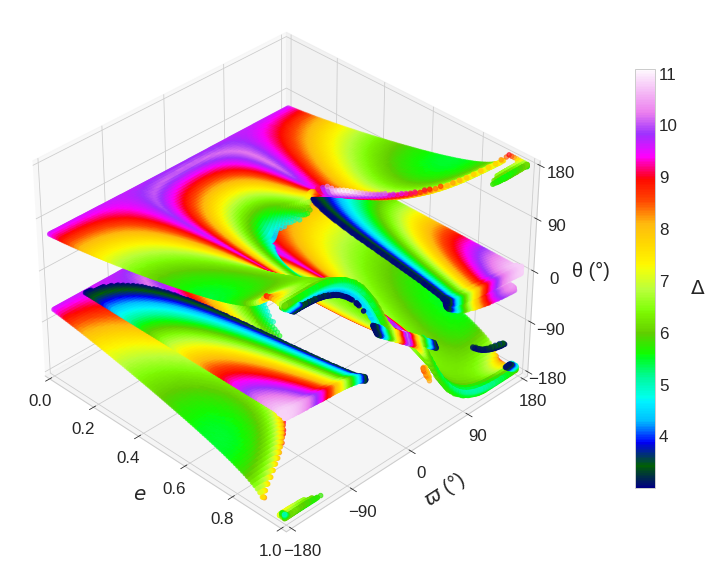

In [8]:
# Normal MinDis surface plot:
plt.style.use('seaborn-whitegrid')
fig4 = plt.figure(figsize=(15,10))
ax = fig4.add_subplot(111, projection='3d')

# Scatter plot:
img2 = ax.scatter(E_sup, W_sup, S_sup, c=color2)

# Labels y ticks:
ax.set(xlabel = '\n$e$', ylabel = '\n'+r'  $\varpi$ (°)')
if (ANGLE == 0):
    ax.set(xlim = [0, 1], ylim = [0, 360], zlim = [0, 360], yticks = angles, zticks = angles)
else:         
    ax.set(xlim = [0, 1], ylim = [-180, 180], zlim = [-180, 180], yticks = angles, zticks = angles)
ax.zaxis.set_rotate_label(False) 
ax.set_zlabel('          ' + res_angle + ' (°)     ', rotation=0)

# Color bar:
cb = plt.colorbar(cm.ScalarMappable(norm=norma2, cmap=colormap2), ax = plt.gca(), 
                   orientation = 'vertical', shrink=0.9, fraction=0.025, pad=0.1)
#ylabel = 'Mín. distance in Rhill'
ylabel = r'$\Delta$'
cb.ax.set_ylabel(ylabel, rotation=0, size=20, labelpad = 20)

# View angle:
ax.view_init(elev=35, azim=315)

plt.show();

# Save image
if (GUARDAR):
    if not os.path.exists(dir_graf):
        os.makedirs(dir_graf)
    fig4.savefig(dir_graf + fileMD_graf, dpi = int(cal), format = formato, bbox_inches='tight');
    print('Saved in: ', dir_graf + fileMD_graf)

In [9]:
# PROGRAM END